In [117]:
 import pandas as pd
 import numpy as np
 import matplotlib.pyplot as plt
 import plotly.express as px # to plot the time series plot
 from sklearn import metrics # for the evaluation
 from sklearn.preprocessing import LabelEncoder,MinMaxScaler
 import tensorflow as tf 

In [119]:
data = pd.read_excel('/content/FinalDF.xlsx')


In [120]:
data.head()

,Unnamed: 0,Date,Summary,Negative,Positive,Neutral,Comp,Open,High,Low,Close,Adj Close,Volume
0,0,2021-01-11,Few companies drive stock market across the wo...,0.021,0.177,0.802,0.9739,1938.800049,1938.800049,1892.500000,1897.250000,1891.166260,15371556
1,1,2021-01-12,"Reliance Industries (RIL) is a good stock?,The...",0.056,0.101,0.843,0.8820,1903.000000,1960.000000,1899.900024,1957.050049,1950.774536,18996047
2,2,2021-01-13,HDFC Bank has replaced Reliance Industries to ...,0.045,0.029,0.927,-0.1280,1963.550049,1974.949951,1918.449951,1938.800049,1932.583130,12284876
3,3,2021-01-14,reliance Bhartiartl drreddy cipla biocon \n m...,0.054,0.038,0.908,-0.1873,1945.000000,1966.900024,1939.050049,1960.599976,1954.313110,9946818
4,4,2021-01-15,"On Friday, Reliance shares fell nearly 4% to R...",0.033,0.155,0.813,0.8957,1960.599976,1973.800049,1920.050049,1937.449951,1931.237305,9503790


In [123]:
for i in data.select_dtypes('object').columns:
   le = LabelEncoder().fit(data[i])
   data[i] = le.transform(data[i]) 
X_scaler = MinMaxScaler()
Y_scaler = MinMaxScaler()
X_data = X_scaler.fit_transform(data[['Negative', 'Positive', 'Neutral', 'Comp']])
Y_data = Y_scaler.fit_transform(data[['Adj Close']])

In [124]:
 def custom_ts_multi_data_prep(dataset, target, start, end, window, horizon):
     X = []
     y = []
     start = start + window
     if end is None:
         end = len(dataset) - horizon
     for i in range(start, end):
         indices = range(i-window, i)
         X.append(dataset[indices])
         indicey = range(i+1, i+1+horizon)
         y.append(target[indicey])
     return np.array(X), np.array(y)

In [125]:
 hist_window = 60
 horizon = 5
 TRAIN_SPLIT = 170
 x_train, y_train = custom_ts_multi_data_prep(X_data, Y_data, 0, TRAIN_SPLIT, hist_window, horizon)
 x_vali, y_vali = custom_ts_multi_data_prep(X_data, Y_data, TRAIN_SPLIT, None, hist_window, horizon) 

In [126]:
 print ('Multiple window of past history\n')
 print(x_train[0])
 print ('\n Target horizon\n')
 print (y_train[0])

Multiple window of past history

[[0.09813084 0.54968944 0.39076923 0.98656678]
 [0.26168224 0.3136646  0.51692308 0.93908551]
 [0.21028037 0.09006211 0.77538462 0.41725652]
 [0.25233645 0.11801242 0.71692308 0.38661844]
 [0.15420561 0.48136646 0.42461538 0.94616378]
 [0.05140187 0.36645963 0.60307692 0.97892018]
 [0.         0.45962733 0.54461538 0.98016017]
 [0.1635514  0.44409938 0.45230769 0.99938001]
 [0.10280374 0.44720497 0.48615385 0.99845001]
 [0.14018692 0.51863354 0.39384615 0.99607337]
 [0.09813084 0.45031056 0.48923077 0.99886334]
 [0.20093458 0.38509317 0.48615385 0.99266339]
 [0.09813084 0.43167702 0.50769231 0.98460346]
 [0.35981308 0.17080745 0.59076923 0.27656936]
 [0.09813084 0.17701863 0.75692308 0.96920692]
 [0.21962617 0.41304348 0.44615385 0.99979334]
 [0.14018692 0.31987578 0.59076923 1.        ]
 [0.20560748 0.35403727 0.51384615 0.99948334]
 [0.18224299 0.28881988 0.59384615 0.98827176]
 [0.15420561 0.27018634 0.63076923 0.99917334]
 [0.17757009 0.2826087  0.6

In [127]:
 batch_size = 256
 buffer_size = 150
 train_data = tf.data.Dataset.from_tensor_slices((x_train, y_train))
 train_data = train_data.cache().shuffle(buffer_size).batch(batch_size).repeat()
 val_data = tf.data.Dataset.from_tensor_slices((x_vali, y_vali))
 val_data = val_data.batch(batch_size).repeat()

In [129]:
lstm_model = tf.keras.models.Sequential([
   tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(200, return_sequences=True), 
                                input_shape=x_train.shape[-2:]),
     tf.keras.layers.Dense(20, activation='tanh'),
     tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(150)),
     tf.keras.layers.Dense(20, activation='tanh'),
     tf.keras.layers.Dense(20, activation='tanh'),
     tf.keras.layers.Dropout(0.25),
     tf.keras.layers.Dense(units=horizon),
 ])
lstm_model.compile(optimizer='adam', loss='mse')
lstm_model.summary() 


Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bidirectional (Bidirectiona  (None, 60, 400)          328000    
 l)                                                              
                                                                 
 dense_9 (Dense)             (None, 60, 20)            8020      
                                                                 
 bidirectional_1 (Bidirectio  (None, 300)              205200    
 nal)                                                            
                                                                 
 dense_10 (Dense)            (None, 20)                6020      
                                                                 
 dense_11 (Dense)            (None, 20)                420       
                                                                 
 dropout (Dropout)           (None, 20)               

In [132]:
model_path = 'Bidirectional_LSTM_Multivariate.h5'
early_stopings = tf.keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=10, verbose=1, mode='min')
checkpoint =  tf.keras.callbacks.ModelCheckpoint(model_path, monitor='val_loss', save_best_only=True, mode='min', verbose=0)
callbacks=[early_stopings,checkpoint] 
history = lstm_model.fit(train_data,epochs=2,steps_per_epoch=100,validation_data=val_data,validation_steps=50,verbose=1,callbacks=callbacks)



Epoch 1/2
100/100 [==============================] - 86s 856ms/step - loss: 0.0035 - val_loss: 0.3144
Epoch 2/2
100/100 [==============================] - 85s 852ms/step - loss: 0.0028 - val_loss: 0.3915


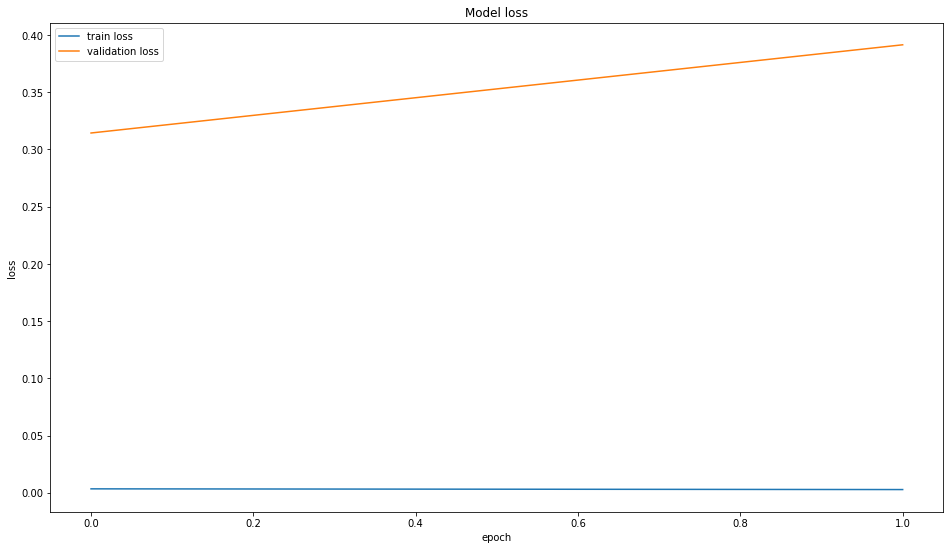

In [133]:
 plt.figure(figsize=(16,9))
 plt.plot(history.history['loss'])
 plt.plot(history.history['val_loss'])
 plt.title('Model loss')
 plt.ylabel('loss')
 plt.xlabel('epoch')
 plt.legend(['train loss', 'validation loss'])
 plt.show()

In [134]:
data_val = X_scaler.fit_transform(data[['Negative', 'Positive', 'Neutral', 'Comp']].tail(60))
val_rescaled = data_val.reshape(1, data_val.shape[0], data_val.shape[1])
pred = lstm_model.predict(val_rescaled)
pred_Inverse = Y_scaler.inverse_transform(pred)
pred_Inverse 

array([[1866.0952, 1850.9084, 1813.3407, 1840.2625, 1834.5975]],
      dtype=float32)